# Few_shot learning with Breagman Divergence for crop pest classification - Maggot insect

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Packages

In [61]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
import multiprocessing as mp

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

#Check GPU support, please do activate GPU
print(torch.cuda.is_available())

True


### Define image size

In [62]:
nH = 96 # image.shape = [nH,nH,3]

## Import/export data

In [ ]:
# # Meta-training
# path_train = '/content/drive/MyDrive/Few_shot_Learning/datasets/IP102_Selected_Data/meta_learning/IP102_maggot/train'
# path_test = '/content/drive/MyDrive/Few_shot_Learning/datasets/IP102_Selected_Data/meta_learning/IP102_maggot/test'

# Classical training
path_train = '/content/drive/MyDrive/Few_shot_Learning/datasets/IP102_Selected_Data/classical_learning/IP102_Maggot/train'
path_test = '/content/drive/MyDrive/Few_shot_Learning/datasets/IP102_Selected_Data/classical_learning/IP102_Maggot/test'

### Read data

In [ ]:
def read_classes(class_path, class_name,nH): 
    datax = []
    datay = []
    images = os.listdir(class_path)
    for img in images:
        image = cv2.resize(cv2.imread(class_path + '/' + img),(nH,nH))
        # image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F) # Normalizing
        
        #rotations of image
        rotated_90 = ndimage.rotate(image, 90)
        rotated_180 = ndimage.rotate(image, 180)
        rotated_270 = ndimage.rotate(image, 270)
        datax.extend((image, rotated_90, rotated_180, rotated_270))
        datay.extend((
            class_name + '_0',
            class_name + '_90',
            class_name + '_180',
            class_name + '_270'
        ))
        
    return np.array(datax), np.array(datay)

In [ ]:
def read_images(base_directory, nH):
    """
    Reads all the alphabets from the base_directory
    Uses multithreading to decrease the reading time drastically
    """
    datax = None
    datay = None
    
    pool = mp.Pool(mp.cpu_count())
    results = [pool.apply(read_classes, args=(base_directory + '/' + directory + '/', directory, nH,
                          )) for directory in os.listdir(base_directory)]
    pool.close()

    # results = [read_classes(base_directory + '/' + directory + '/', directory) for directory in os.listdir(base_directory)]

    for result in results:
        if datax is None:
            datax = result[0]
            datay = result[1]
        else:
            datax = np.vstack([datax, result[0]])
            datay = np.concatenate([datay, result[1]])
    return datax, datay

In [ ]:
%%time 
trainx, trainy = read_images(path_train,nH)

Process ForkPoolWorker-2:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


KeyboardInterrupt: ignored

Process ForkPoolWorker-1:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "<ipython-input-8-0f1e27289d0d>", line 6, in read_classes
    image = cv2.resize(cv2.imread(class_path + '/' + img),(nH,nH))
KeyboardInterrupt


In [ ]:
%%time 
testx, testy = read_images(path_test, nH)

In [ ]:
trainx.shape, trainy.shape, testx.shape, testy.shape

### Save npy data

In [ ]:
# Set path and names to save data
# Meta-training
# path = '/content/drive/MyDrive/Few_shot_Learning/datasets/IP102_Selected_Data/meta_learning/IP102_maggot'

# Classical training
# path = '/content/drive/MyDrive/Few_shot_Learning/datasets/IP102_Selected_Data/classical_learning/IP102_Maggot'

trainx_name = 'trainx'
trainy_name = 'trainy'
testx_name = 'testx'
testy_name = 'testy'

# # Save data (.npy format)
# np.save(path + '/' + trainx_name, trainx)
# np.save(path + '/' + trainy_name, trainy)
# np.save(path + '/' + testx_name, testx)
# np.save(path + '/' + testy_name, testy)

trainx.shape, trainy.shape, testx.shape, testy.shape

((8000, 96, 96, 3), (8000,), (4000, 96, 96, 3), (4000,))

## Load npy data

In [63]:
# Set path and names to load data
# Meta-training
# path = '/content/drive/MyDrive/Few_shot_Learning/datasets/IP102_Selected_Data/meta_learning/IP102_maggot'

# Classical training
path = '/content/drive/MyDrive/Few_shot_Learning/datasets/IP102_Selected_Data/classical_learning/IP102_Maggot'

trainx_name = 'trainx'
trainy_name = 'trainy'
testx_name = 'testx'
testy_name = 'testy'

# Import data - Read numpy file (.npy)
trainx = np.load(path + '/' + trainx_name + '.npy')
trainy = np.load(path + '/' + trainy_name + '.npy')
testx = np.load(path + '/' + testx_name + '.npy')
testy = np.load(path + '/' + testy_name + '.npy')

trainx.shape, trainy.shape, testx.shape, testy.shape

((8000, 96, 96, 3), (8000,), (4000, 96, 96, 3), (4000,))

## Create samples

In [64]:
def extract_sample(n_way, n_support, n_query, datax, datay):
  """
  Picks random sample of size n_support+n_querry, for n_way classes
  Args:
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      datax (np.array): dataset of images
      datay (np.array): dataset of labels
  Returns:
      (dict) of:
        (torch.Tensor): sample of images. Size (n_way, n_support+n_query, (dim))
        (int): n_way
        (int): n_support
        (int): n_query
  """
  sample = []
  K = np.random.choice(np.unique(datay), n_way, replace=False)
  for cls in K:
    datax_cls = datax[datay == cls]
    perm = np.random.permutation(datax_cls)
    sample_cls = perm[:(n_support+n_query)]
    sample.append(sample_cls)
  sample = np.array(sample)
  sample = torch.from_numpy(sample).float()
  sample = sample.permute(0,1,4,2,3)
  return({
      'images': sample,
      'n_way': n_way,
      'n_support': n_support,
      'n_query': n_query
      })

In [65]:
def display_sample(sample):
  """
  Displays sample in a grid
  Args:
      sample (torch.Tensor): sample of images to display
  """
  #need 4D tensor to create grid, currently 5D
  sample_4D = sample.view(sample.shape[0]*sample.shape[1],*sample.shape[2:])
  #make a grid
  out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
  plt.figure(figsize = (16,7))
  plt.imshow(out.permute(1, 2, 0))

As an example, let's pick a sample

*   n_way = 8
*   n_support = 5
*   n_query = 5

torch.Size([8, 10, 3, 96, 96])

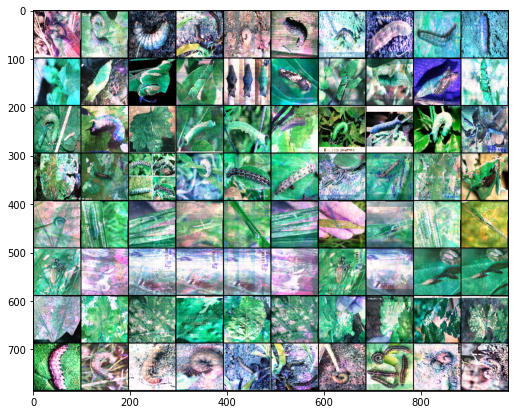

In [66]:
sample_example = extract_sample(8, 5, 5, trainx, trainy)
# display_sample(sample_example['images'])
display_sample(F.normalize(sample_example['images'], p=10, dim=0))
sample_example['images'].shape # [N, k+q, chanels, width, height]

In [67]:
# print(F.normalize(sample_example['images'], p=10, dim=0))

## Build model

### Model

In [68]:
class Flatten(nn.Module):
  def __init__(self):
    super(Flatten, self).__init__()

  def forward(self, x):
    return x.view(x.size(0), -1)

def load_protonet_conv(**kwargs): # **kwargs significa que a função recebe os parâmetros em forma de dicionário
  """
  Loads the prototypical network model
  Arg:
      x_dim (tuple): dimension of input image
      hid_dim (int): dimension of hidden layers in conv blocks
      z_dim (int): dimension of embedded image
  Returns:
      Model (Class ProtoNet)
  """
  x_dim = kwargs['x_dim']
  hid_dim = kwargs['hid_dim']
  z_dim = kwargs['z_dim']

  def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.MaxPool2d(3)
        )
    
  encoder = nn.Sequential(
    conv_block(x_dim[0], hid_dim),
    conv_block(hid_dim, hid_dim),
    conv_block(hid_dim, hid_dim),
    # conv_block(hid_dim, hid_dim),
    # conv_block(hid_dim, hid_dim),
    conv_block(hid_dim, z_dim),
    Flatten()
    # Usar um dropout(0,5) aqui para testes também
    )
    
  return ProtoNet(encoder)

### Summary model

In [ ]:
# from torchsummary import summary

# # A função a baixo foi copiada aqui apenas para plotar o resumo do modelo.
# # Foi alterada a saída de "return ProtoNet(encoder)" para "return encoder"
# def load_protonet_conv_copy(**kwargs): 
#   """
#   Loads the prototypical network model
#   Arg:
#       x_dim (tuple): dimension of input image
#       hid_dim (int): dimension of hidden layers in conv blocks
#       z_dim (int): dimension of embedded image
#   Returns:
#       Model (Class ProtoNet)
#   """
#   x_dim = kwargs['x_dim']
#   hid_dim = kwargs['hid_dim']
#   z_dim = kwargs['z_dim']

#   def conv_block(in_channels, out_channels):
#     return nn.Sequential(
#         nn.Conv2d(in_channels, out_channels, 3, padding=1),
#         nn.BatchNorm2d(out_channels),
#         nn.ReLU(),
#         nn.Dropout(0.1),
#         nn.MaxPool2d(3)
#         )
    
#   encoder = nn.Sequential(
#     conv_block(x_dim[0], hid_dim),
#     conv_block(hid_dim, hid_dim),
#     conv_block(hid_dim, hid_dim),
#     # conv_block(hid_dim, hid_dim),
#     # conv_block(hid_dim, hid_dim),
#     conv_block(hid_dim, z_dim),
#     Flatten()
#     )
    
#   return encoder

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
# model = load_protonet_conv_copy(
#     x_dim=(3,nH,nH),
#     hid_dim=64,
#     z_dim=128,
#     ).to(device)

# summary(model, (3, nH, nH))  
# # print(model)

### Encoder

In [69]:
class ProtoNet(nn.Module):
  def __init__(self, encoder):
    """
    Args:
        encoder : CNN encoding the images in sample
        n_way (int): number of classes in a classification task
        n_support (int): number of labeled examples per class in the support set
        n_query (int): number of labeled examples per class in the query set
    """
    super(ProtoNet, self).__init__()
    self.encoder = encoder.cuda()

  def set_forward_loss(self, sample, divergence):
    """
    Computes loss, accuracy and output for classification task
    Args:
        sample (torch.Tensor): shape (n_way, n_support+n_query, (dim)) 
    Returns:
        torch.Tensor: shape(2), loss, accuracy and y_hat
    """
    sample_images = sample['images'].cuda()
    n_way = sample['n_way']
    n_support = sample['n_support']
    n_query = sample['n_query']

    x_support = sample_images[:, :n_support]
    x_query = sample_images[:, n_support:]
   
    #target indices are 0 ... n_way-1
    target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
    target_inds = Variable(target_inds, requires_grad=False)
    target_inds = target_inds.cuda()
   
    #encode images of the support and the query set
    x = torch.cat([x_support.contiguous().view(n_way * n_support, *x_support.size()[2:]),
                   x_query.contiguous().view(n_way * n_query, *x_query.size()[2:])], 0)
    z = self.encoder.forward(x)
    z_dim = z.size(-1)

    # Z_PROTO
    z_proto = z[:n_way*n_support]#.view(n_way, n_support, z_dim).mean(1)

    # Z_QUERY
    z_query = z[n_way*n_support:]

    # COMPUTE DISTANCES
    # --- Euclidean ---
    if divergence == "euclidean":
      dists = euclidean_dist(z_query, z_proto.view(n_way, n_support, z_dim).mean(1))
    
    # --- Mahalanobis ---
    elif divergence == "mahalanobis":
      dists = torch.zeros((n_query*n_way, 1)).to(device = 'cuda')
      for i in range(0, n_support*n_way, n_support):
        mahal = mahalanobis_dist(z_query, z_proto[i:i + n_support, :])
        dists = torch.cat((dists, mahal),  1)
      dists = dists[:, 1:]

    # --- Kullback–Leibler – KL ---
    elif divergence == "KL":
      xx = z_query / (z_query.sum(1).expand(z_dim, n_query*n_way).T)
      yy = z_proto.view(n_way, n_support, z_dim).mean(1)
      yy = yy / (yy.sum(1).expand(z_dim, n_way).T)
      dists = KL_dist(xx, yy)

    # --- Itakura–Saito - IS ---
    elif divergence == "IS":
      xx = z_query / (z_query.sum(1).expand(z_dim, n_query*n_way).T)
      yy = z_proto.view(n_way, n_support, z_dim).mean(1)
      yy = yy / (yy.sum(1).expand(z_dim, n_way).T) 
      dists = IS_dist(xx, yy)

    #compute probabilities
    log_p_y = F.log_softmax(-dists, dim=1).view(n_way, n_query, -1)
    # print("log_p_y", log_p_y.shape)
   
    loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
    # print("loss_val", loss_val)
    _, y_hat = log_p_y.max(2)
    acc_val = torch.eq(y_hat, target_inds.squeeze()).float().mean()
    # print("acc_val", acc_val)
   
    return loss_val, {
        'loss': loss_val.item(),
        'acc': acc_val.item(),
        'y_hat': y_hat
        }

## Bregman divergence
https://en.wikipedia.org/wiki/Bregman_divergence#cite_note-4

### Euclidean

In [70]:
def euclidean_dist(x, y): # Recebe z_query (N*q x z_din) e z_proto (N x z_din) com média dos vetores de suporte por classe
  """
  Computes euclidean distance btw x and y
  Args:
      x (torch.Tensor): shape (n, d). n usually n_way*n_query
      y (torch.Tensor): shape (m, d). m usually n_way
  Returns:
      torch.Tensor: shape(n, m). For each query, the distances to each centroid
  """
  # print('query: ', x.shape)
  # print('proto: ', y.shape)

  n = x.size(0)
  m = y.size(0)
  d = x.size(1)
  assert d == y.size(1)

  x = x.unsqueeze(1).expand(n, m, d)
  y = y.unsqueeze(0).expand(n, m, d)
  # print('query: ', x.shape)
  # print('proto: ', y.shape)
  # print('distances: ', torch.pow(x - y, 2).sum(2).shape)
  # print('\n')
  return torch.pow(x - y, 2).sum(2).type(torch.double)

### Mahalanobis

In [71]:
# Compute covariance pytorch
def cov(x, rowvar=False, bias=False, ddof=None, aweights=None):
    """Estimates covariance matrix like numpy.cov"""
    # ensure at least 2D
    if x.dim() == 1:
        x = x.view(-1, 1)

    # treat each column as a data point, each row as a variable
    if rowvar and x.shape[0] != 1:
        x = x.t()

    if ddof is None:
        if bias == 0:
            ddof = 1
        else:
            ddof = 0

    w = aweights
    if w is not None:
        if not torch.is_tensor(w):
            w = torch.tensor(w, dtype=torch.float)
        w_sum = torch.sum(w)
        avg = torch.sum(x * (w/w_sum)[:,None], 0)
    else:
        avg = torch.mean(x, 0)

    # Determine the normalization
    if w is None:
        fact = x.shape[0] - ddof
    elif ddof == 0:
        fact = w_sum
    elif aweights is None:
        fact = w_sum - ddof
    else:
        fact = w_sum - ddof * torch.sum(w * w) / w_sum

    xm = x.sub(avg.expand_as(x))

    if w is None:
        X_T = xm.t()
    else:
        X_T = torch.mm(torch.diag(w), xm).t()

    c = torch.mm(X_T, xm)
    c = c / fact

    return c.squeeze()

In [72]:
def mahalanobis_dist(x, y):
    """
    Computes Mahalanobis distance between each from x and distribution y
    Args:
        x (torch.Tensor): shape (n, d). n usually n_way*n_query
        y (torch.Tensor): shape (m, d). m usually n_support
    Returns:
        torch.Tensor: shape(n, 1). For each query, the distance from distribution y
    """
    # Compute covariance matrix
    covy = cov(y.T)
    
    # Compute inverse of covariance matrix
    cov_Inv = torch.inverse(covy)

    # Extract mean to compute x-m
    y = y.mean(0).view(1, y.shape[1]).repeat(y.shape[0], 1)

    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    assert d == y.size(1)

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)
    
    x_minus_m = (x - y).sum(2)
    
    # Compute Mahalanobis distances
    mahal_dists = torch.mm(torch.mm(x_minus_m, cov_Inv), x_minus_m.T) / 1000
    
    return torch.diagonal(mahal_dists).view(x_minus_m.shape[0], 1).type(torch.double)

### Kullback–Leibler - KL

In [129]:
def KL_dist(x, y): # Recebe z_query (N*q x z_din) e z_proto (N x z_din) com média dos vetores de suporte por classe
    """"KL (p || q)"""

    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    assert d == y.size(1)

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    # Since log (0) is negative infinity, let's replace the zeros with an approximate value
    y_subs_zero = torch.where(y >  0., y.type(torch.double), 0.01)
    x_subs_zero = torch.where(x > 0., x.type(torch.double), 0.01)

    # KL divergence
    kl_div = x_subs_zero * torch.log(x_subs_zero / y_subs_zero)

    return (kl_div.sum(2) * 100).type(torch.double)

### Itakura–Saito - IS

In [130]:
def IS_dist(x, y):
    """"I-S (p || q)"""

    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    assert d == y.size(1)

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)
    
    # Since log (0) is negative infinity, let's replace the zeros with an approximate value
    y_subs_zero = torch.where(y >  0., y.type(torch.double), 0.001)
    x_subs_zero = torch.where(x > 0., x.type(torch.double), 0.001)

    # IS divergence
    is_div = (x_subs_zero /  y_subs_zero) - torch.log(x_subs_zero / y_subs_zero) - 1
    
    return is_div.sum(2).type(torch.double)

## Train

In [75]:
from tqdm import tqdm_notebook
from tqdm import tnrange

In [76]:
# Adicionei essa função para visualizar o historico de treinamento da rede
# Plot history graphc 
def plot_history(history):
  # x = range(1, len(history["hist_acc"]) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(history["hist_epoch"], history["hist_acc"], 'b', label='Training acc')
  plt.title('Training accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history["hist_epoch"], history["hist_loss"], 'r', label='Training loss')
  plt.title('Training loss')
  plt.legend() 

In [77]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size, divergence):
  """
  Trains the protonet
  Args:
      model
      optimizer
      train_x (np.array): images of training set
      train_y(np.array): labels of training set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      max_epoch (int): max epochs to train on
      epoch_size (int): episodes per epoch
  """
  #divide the learning rate by 2 at each epoch, as suggested in paper
  scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
  epoch = 0 #epochs done so far
  stop = False #status to know when to stop

  while epoch < max_epoch and not stop:
    running_loss = 0.0
    running_acc = 0.0

    for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):
      sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
      optimizer.zero_grad()
      loss, output = model.set_forward_loss(sample, divergence)

      # loss.requires_grad = True # Adicionei esta linha
      
      running_loss += output['loss']
      running_acc += output['acc']
      loss.backward()
      optimizer.step()
    epoch_loss = running_loss / epoch_size
    epoch_acc = running_acc / epoch_size
    print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))

# Adicionei para plotar o histórico
    history["hist_loss"].append(epoch_loss)
    history["hist_acc"].append(epoch_acc)
    history["hist_epoch"].append(epoch+1)   # */ 

    epoch += 1
    scheduler.step()

In [123]:
%%time
# Adicionei para plotar o histórico
history = {"hist_loss": [], "hist_acc": [], "hist_epoch": []}

model = load_protonet_conv(
    x_dim=(3,nH,nH),
    hid_dim=64,
    z_dim=128,
    )

optimizer = optim.Adam(model.parameters(), lr = 0.001)

n_way = 3
n_support = 5
n_query = 4

train_x = trainx
train_y = trainy

max_epoch = 10
epoch_size = 2000

# --- Choose Bregman Divergence ---
# Euclidean:         "euclidean"
# Mahalanobis:       "mahalanobis"
# Kullback–Leibler:  "KL"
# Itakura-Saito:     "IS"

divergence = "KL" 

train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size, divergence)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`



Epoch 1 -- Loss: 0.4333 Acc: 0.7969



Epoch 2 -- Loss: 0.3387 Acc: 0.8433



Epoch 3 -- Loss: 0.3060 Acc: 0.8568



Epoch 4 -- Loss: 0.2780 Acc: 0.8738



Epoch 5 -- Loss: 0.2676 Acc: 0.8773



Epoch 6 -- Loss: 0.2595 Acc: 0.8818



Epoch 7 -- Loss: 0.2496 Acc: 0.8863



Epoch 8 -- Loss: 0.2482 Acc: 0.8888



Epoch 9 -- Loss: 0.2421 Acc: 0.8915



Epoch 10 -- Loss: 0.2351 Acc: 0.8938
CPU times: user 4min 26s, sys: 5.44 s, total: 4min 31s
Wall time: 4min 34s


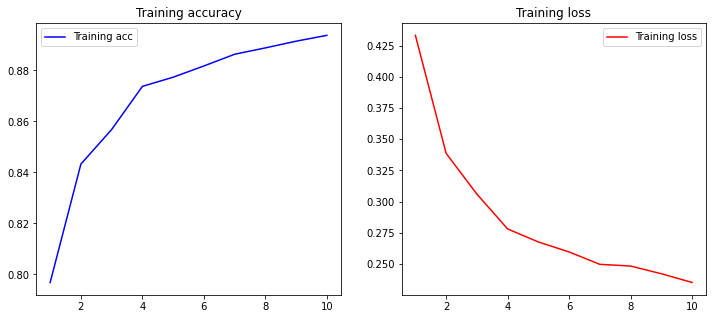

In [124]:
plot_history(history)

## Test

In [125]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode, divergence):
  """
  Tests the protonet
  Args:
      model: trained model
      test_x (np.array): images of testing set
      test_y (np.array): labels of testing set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      test_episode (int): number of episodes to test on
  """
  running_loss = 0.0
  running_acc = 0.0
  for episode in tnrange(test_episode):
    sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
    loss, output = model.set_forward_loss(sample, divergence)
    running_loss += output['loss']
    running_acc += output['acc']
  avg_loss = running_loss / test_episode
  avg_acc = running_acc / test_episode
  print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

In [128]:
n_way = 3
n_support = 5
n_query = 4

test_x = testx
test_y = testy

test_episode = 1000

test(model, test_x, test_y, n_way, n_support, n_query, test_episode, divergence)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  from ipykernel import kernelapp as app



Test results -- Loss: 0.2779 Acc: 0.8762


## Test on specific example

Let's test the model on a specific example to visualize how well does it label the data

torch.Size([3, 9, 3, 96, 96])

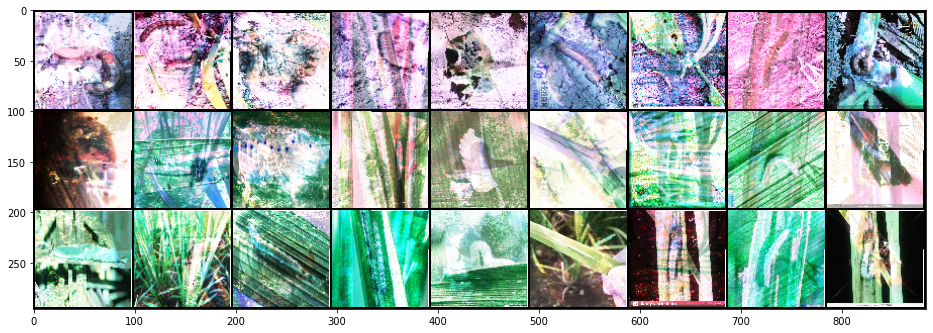

In [136]:
my_sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
# display_sample(my_sample['images'])
display_sample(F.normalize(my_sample['images'], p=5, dim=0))
my_sample['images'].shape

In [138]:
my_loss, my_output = model.set_forward_loss(my_sample, divergence)
my_output

{'acc': 1.0, 'loss': 0.03276835562577194, 'y_hat': tensor([[0, 0, 0, 0],
         [1, 1, 1, 1],
         [2, 2, 2, 2]], device='cuda:0')}

In [ ]:
print((4+4+2)/(12))

0.8333333333333334
